# Taxonomy Plots

After the backend files are generated above, that data can be used to determine the relative abunences of each Phylum or Family in the samples, and plot them in different ways

In [1]:
import sys
sys.path.append('..')
import os
from itertools import chain
from collections import defaultdict
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
BASE = '../data'
OUT = BASE + '/tax_data'

metadata = pd.read_csv(os.path.join(BASE,"filt_metadata.csv"), index_col=0)
samp_names = list(metadata.index)

In [3]:
# Fix sample titles to match what we're calling them in manuscript
metadata['category'] = metadata['category'].str.replace('RT', 'IBD')
#metadata['category'] = metadata['category'].str.replace('RAG', 'RAG${}^{-/-}$')

In [4]:
sample_pairs = metadata.reset_index().set_index(['enriched', 'technical']).sort_index().groupby(level=[0,1])

pairs = []
for x, y in sample_pairs:
    pairs.append(list(y['index'].values))

n14_samps = metadata.query('~n15').index.tolist()
n15_samps = metadata.query('n15').index.tolist()

n14_un_samps = metadata.query('~enriched and ~n15').index.tolist()
n15_un_samps = metadata.query('~enriched and n15').index.tolist()

n14_enr_samps = metadata.query('enriched and ~n15').index.tolist()
n15_enr_samps = metadata.query('enriched and n15').index.tolist()

In [5]:
all_dfs = defaultdict(dict)

for rank in ['family', 'phylum']:
    all_dfs[rank] = pd.read_csv(os.path.join(OUT,"{}_count.csv".format(rank)), index_col=0)

In [6]:
all_dfs['phylum'].head()

,count,organism_name,taxid,sample
7711,1690.711194,chordata,7711,CL_Mix_Pool_N_5
1117,865.068930,cyanobacteria,1117,CL_Mix_Pool_N_5
1239,316.220212,firmicutes,1239,CL_Mix_Pool_N_5
976,248.654522,bacteroidetes,976,CL_Mix_Pool_N_5
74201,167.588248,verrucomicrobia,74201,CL_Mix_Pool_N_5


In [7]:
def pivot_df(df, rank, samples, cutoff = .02):
    
    df_pivot = df.pivot_table(values="count", index="sample", columns="organism_name").dropna(1, thresh=3)

    bad_fams = ['muridae', 'poaceae', 'hominidae', 'phormidiaceae']
    bad_phyla = ['chordata', 'cyanobacteria']
   
    order = ['other'] + list(df_pivot.sum().sort_values().index)
    order = [o for o in order if not o in bad_fams+bad_phyla]

    
    df_pivot = df_pivot.loc[samples]
    
    
    if rank == "family":
        for bad_fam in bad_fams:
            if bad_fam in df_pivot:
                del df_pivot[bad_fam]
    elif rank == "phylum":
        for bad_phylum in bad_phyla:
            if bad_phylum in df_pivot:
                del df_pivot[bad_phylum]
    df_pivot.to_csv(os.path.join(OUT,"{}_count_pivot.csv".format(rank)))
    
    df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
    df_pivot = df_pivot[df_pivot.columns[df_pivot.sum()> cutoff]]
    df_pivot = df_pivot[[o for o in order if o in df_pivot]]
    other = pd.Series(1-df_pivot.sum(axis=1), name = "Other")
    df_pivot['other'] = other
    df_pivot = df_pivot[[-1]+list(range(len(df_pivot.columns)-1))]
    df_pivot.index = [metadata.loc[x, 'category'].split(' ')[0]+' '+str(metadata.loc[x, 'technical']) for x in df_pivot.index]
    df_pivot = df_pivot.sort_index()
    return df_pivot

In [8]:
def pick_colors(pal):

    order = []
    tot = len(pal)
    for i in range(tot//2):
        order.append(i)
        if tot % 2 == 0:
            order.append(int(tot/2+i))
        else:
            order.append(int(tot/2+i)+1)
    if tot % 2 == 1:
        order.append(int(tot/2))

    return [pal[n] for n in order]
        

def plot_tax(df_pivot):
    from matplotlib.ticker import FuncFormatter
    #from matplotlib import rc
    from itertools import cycle
    import matplotlib
    
    #rc('text', usetex=True)
    
    def to_percent(y, position):
        s = str(100 * y)
        if matplotlib.rcParams['text.usetex'] is True:
            return s + r'$\%$'
        else:
            return s + '%'
    
    sns.set_style('whitegrid')
    f = plt.figure(figsize=(6,5))

    #Fix column names :Capitalize
    order = df_pivot.columns.tolist()
    order = [o[:1].upper() + o[1:] for o in order]
    df_pivot.columns = order
    
    # Filter out missing famalies for consistant coloring
    #colors = pick_colors(sns.husl_palette(len(order)+1, h=.2, l=.55, s=1))
    colors = sns.color_palette('muted') + sns.xkcd_palette(["clay"]) + sns.color_palette('Set2', 8)
    c_dict = dict(zip(order[::-1], cycle(colors)))
    
    ax = df_pivot.plot.bar(stacked=True, legend = 'reverse', ylim=(0,1), ax=f.gca(),  color=map(c_dict.get,df_pivot.columns))
    lgd = plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    lgd = plt.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size':12, 'style':'italic'})
    ax.set_ylabel("Normalized Count", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 12)
    plt.xlabel('')
    ax.title.set_fontsize(20)
    formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(formatter)
    f.subplots_adjust(right=0.8)

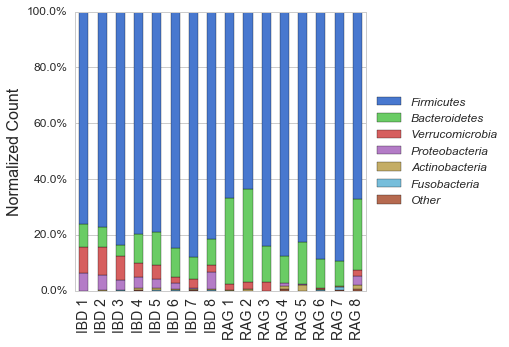

In [9]:
plot_tax(pivot_df(all_dfs['phylum'], 'phylum', n14_un_samps+n15_un_samps))

In [10]:
un_phy = pivot_df(all_dfs['phylum'], 'phylum', n14_un_samps+n15_un_samps)
un_phy = un_phy.reset_index()
un_phy = un_phy.rename(columns={'index': 'cohort'})
un_phy['cohort'] = un_phy['cohort'].str.split(' ').str[0]

un_phy_avg = un_phy.groupby('cohort').mean()

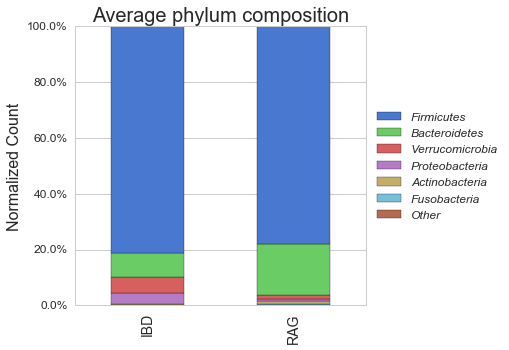

In [11]:
plot_tax(un_phy_avg)
plt.title('Average phylum composition', size = 20)
plt.savefig(os.path.join(BASE, 'tax_phylum_avg.svg'))

In [12]:
from scipy import stats

In [13]:
def test_tax_diff(df):
    taxs = list(df.columns)
    taxs.remove('cohort')
    
    
    results = []
    for i, tax in enumerate(taxs[::-1]):
        ibd = df.query('cohort == "IBD"')[tax].dropna()
        rag = df.query('cohort == "RAG"')[tax].dropna()

        res = stats.ttest_ind(ibd, rag)

        if res[0] == res[0]:
            results.append((tax, res[0], res[1]))

    unadj_sig_res = [(tax, t, p) for (tax, t, p) in results if p < 0.05]
    adj_res = [(tax, t, p*(len(results))) for (tax, t, p) in results]
    sig_res = [(tax, t, p) for (tax, t, p) in adj_res if p < 0.05]

    return(sig_res, unadj_sig_res, adj_res)

In [14]:
def mwu_tax_diff(df):
    taxs = list(df.columns)
    taxs.remove('cohort')
    
    
    results = []
    for i, tax in enumerate(taxs[::-1]):
        ibd = df.query('cohort == "IBD"')[tax].dropna()
        rag = df.query('cohort == "RAG"')[tax].dropna()

        res = stats.mannwhitneyu(ibd, rag)

        if res[0] == res[0]:
            results.append((tax, res[0], res[1]))

    unadj_sig_res = [(tax, t, p) for (tax, t, p) in results if p < 0.05]
    adj_res = [(tax, t, p*(len(results))) for (tax, t, p) in results]
    sig_res = [(tax, t, p) for (tax, t, p) in adj_res if p < 0.05]

    return(sig_res, unadj_sig_res, adj_res)

In [15]:
def plot_swarm(result, dat, title):
    
    fig, ax = plt.subplots(len(result), 1)
    fig.set_size_inches(5, 3*len(result))

    for i, (tax, t, p) in enumerate(result):

        sns.swarmplot(y=tax, x='cohort', data=dat, ax = ax[i])

        # distance across the "X" or "Y" stipplot column to span, in this case 40%
        median_width = 0.3

        for tick, text in zip(ax[i].get_xticks(), ax[i].get_xticklabels()):
            cohort_name = text.get_text()  # "X" or "Y"

            # calculate the median value for all replicates of either X or Y
            median_val = dat.query('cohort == "{}"'.format(cohort_name))[tax].median()

            # plot horizontal lines across the column, centered on the tick
            ax[i].plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                    lw=4, color='k')
        ax[i].set_ylim(bottom=0)
        ax[i].set_ylabel('Fraction', size=14)
        ax[i].set_xlabel('')
        ax[i].set_title(tax[0].upper()+tax[1:], size=14, style='italic')
        ax[i].set_xticklabels(ax[i].get_xticklabels(), size=14)
    plt.savefig(os.path.join(BASE, '{}.svg'.format(title.replace(' ', '_'))))

In [16]:
test_tax_diff(un_phy)[2]

[('firmicutes', 0.61346615484582767, 3.8458429119923938),
 ('bacteroidetes', -2.6230631486424207, 0.1403910468418339),
 ('verrucomicrobia', 3.3790310266123704, 0.034561249294805703),
 ('proteobacteria', 3.2149346652227178, 0.05196746013401865),
 ('actinobacteria', -1.9118355085601126, 0.56046399043387285),
 ('fusobacteria', -1.4876609807999632, 1.2630761393409375),
 ('other', -1.3603719809080907, 1.3664989367218778)]

In [17]:
test_tax_diff(un_phy)[1]

[('bacteroidetes', -2.6230631486424207, 0.020055863834547698),
 ('verrucomicrobia', 3.3790310266123704, 0.0049373213278293858),
 ('proteobacteria', 3.2149346652227178, 0.0074239228762883781)]

In [19]:
test_tax_diff(un_phy)

([('verrucomicrobia', 3.3790310266123704, 0.034561249294805703)],
 [('bacteroidetes', -2.6230631486424207, 0.020055863834547698),
  ('verrucomicrobia', 3.3790310266123704, 0.0049373213278293858),
  ('proteobacteria', 3.2149346652227178, 0.0074239228762883781)],
 [('firmicutes', 0.61346615484582767, 3.8458429119923938),
  ('bacteroidetes', -2.6230631486424207, 0.1403910468418339),
  ('verrucomicrobia', 3.3790310266123704, 0.034561249294805703),
  ('proteobacteria', 3.2149346652227178, 0.05196746013401865),
  ('actinobacteria', -1.9118355085601126, 0.56046399043387285),
  ('fusobacteria', -1.4876609807999632, 1.2630761393409375),
  ('other', -1.3603719809080907, 1.3664989367218778)])

In [18]:
mwu_tax_diff(un_phy)

([('verrucomicrobia', 2.0, 0.011084291335798413)],
 [('bacteroidetes', 10.0, 0.011974337439879718),
  ('verrucomicrobia', 2.0, 0.0015834701908283447),
  ('proteobacteria', 5.0, 0.0084623442342265792)],
 [('firmicutes', 30.0, 3.0618909193223534),
  ('bacteroidetes', 10.0, 0.083820362079158023),
  ('verrucomicrobia', 2.0, 0.011084291335798413),
  ('proteobacteria', 5.0, 0.059236409639586055),
  ('actinobacteria', 13.0, 0.55952469141790617),
  ('fusobacteria', 5.0, 1.2815479606792115),
  ('other', 31.0, 3.3495062336231829)])

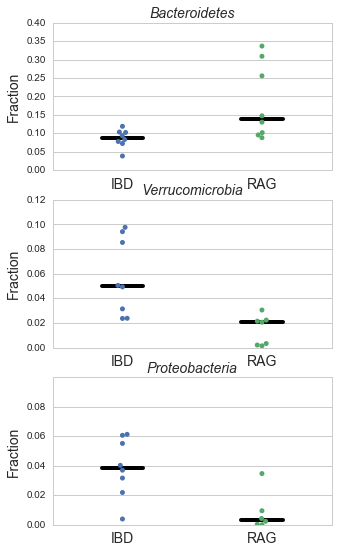

In [20]:
plot_swarm(test_tax_diff(un_phy)[1], un_phy, 'swarm_unenriched_phylum')

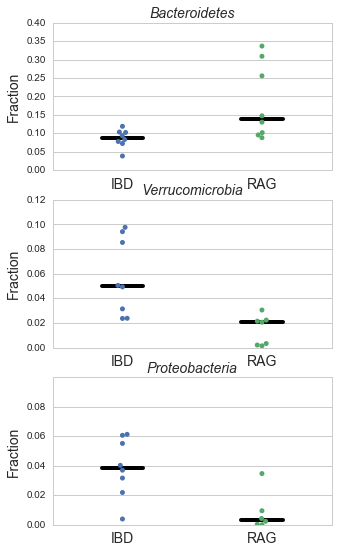

In [21]:
plot_swarm(mwu_tax_diff(un_phy)[1], un_phy, 'swarm_unenriched_phylum')

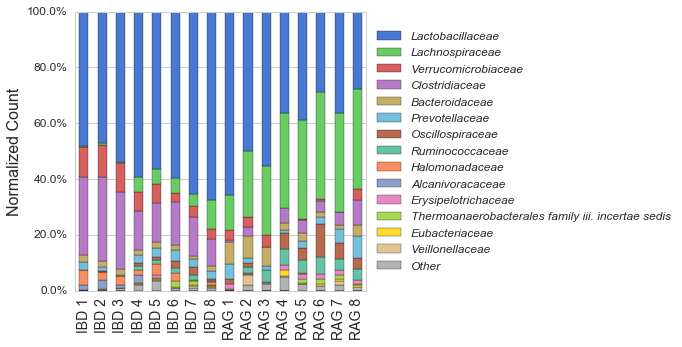

In [18]:
plot_tax(pivot_df(all_dfs['family'], 'family', n14_un_samps+n15_un_samps, cutoff=.05))

In [19]:
un_fam = pivot_df(all_dfs['family'], 'family', n14_un_samps+n15_un_samps, cutoff=.05)
un_fam = un_fam.reset_index()
un_fam = un_fam.rename(columns={'index': 'cohort'})
un_fam['cohort'] = un_fam['cohort'].str.split(' ').str[0]

un_fam_avg = un_fam.groupby('cohort').mean()

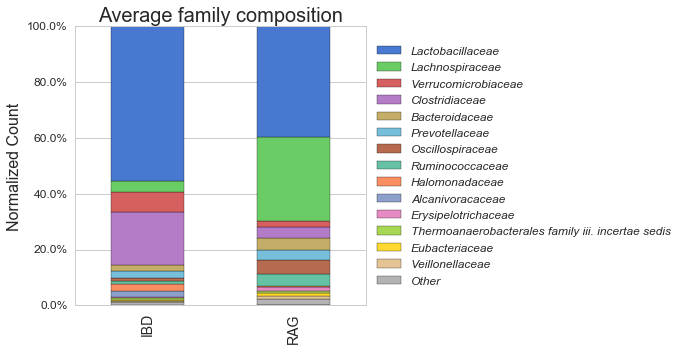

In [20]:
plot_tax(un_fam_avg)
plt.title('Average family composition', size=20)
plt.xlabel('')
plt.savefig(os.path.join(BASE, 'tax_unenriched_fam_avg.svg'))

In [21]:
test_tax_diff(un_fam)[2]

[('lactobacillaceae', 2.7434674948684434, 0.22185680950902434),
 ('lachnospiraceae', -7.705726112312183, 2.957640602890996e-05),
 ('verrucomicrobiaceae', 3.3679216841040382, 0.070614419954673727),
 ('clostridiaceae', 5.0382185106181572, 0.0025371263542347993),
 ('bacteroidaceae', -2.5595862215611378, 0.31768005311562147),
 ('prevotellaceae', -0.94177484835411485, 5.0718637345029318),
 ('oscillospiraceae', -2.6412163654042047, 0.30135503893912474),
 ('ruminococcaceae', -6.6309903704452324, 0.00033966820658379852),
 ('halomonadaceae', 2.1198543763618067, 0.93576480672526208),
 ('erysipelotrichaceae', -3.6546330972105423, 0.053059168672138564),
 ('thermoanaerobacterales family iii. incertae sedis',
  -0.31006215013600574,
  10.690025244812452),
 ('eubacteriaceae', -2.2000967869185826, 0.73405469736169904),
 ('veillonellaceae', -1.5629119307862394, 2.1938027294020968),
 ('other', -1.4930404530874457, 2.2066474318859646)]

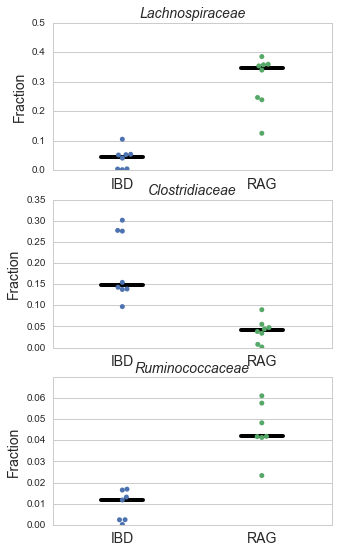

In [22]:
plot_swarm(test_tax_diff(un_fam)[0], un_fam, 'swarm_unenriched_family')

# ENRICHED

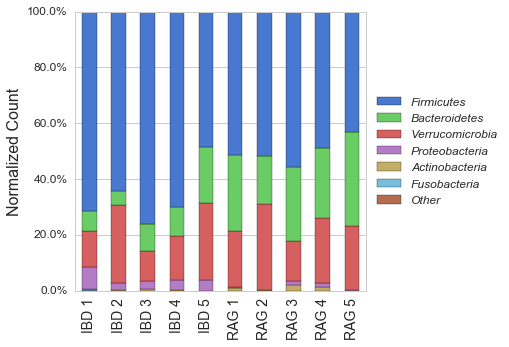

In [23]:
plot_tax(pivot_df(all_dfs['phylum'], 'phylum', n14_enr_samps+n15_enr_samps, cutoff=.001))

In [24]:
enr_phy = pivot_df(all_dfs['phylum'], 'phylum', n14_enr_samps+n15_enr_samps, cutoff = .001)
enr_phy = enr_phy.reset_index()
enr_phy = enr_phy.rename(columns={'index': 'cohort'})
enr_phy['cohort'] = enr_phy['cohort'].str.split(' ').str[0]

enr_phy_avg = enr_phy.groupby('cohort').mean()

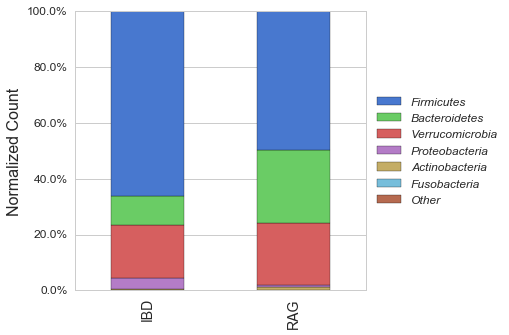

In [25]:
plot_tax(enr_phy_avg)

In [26]:
# Adjusted Pvalus
test_tax_diff(enr_phy)[0]

[('bacteroidetes', -4.1774972564877295, 0.015450962166211158)]

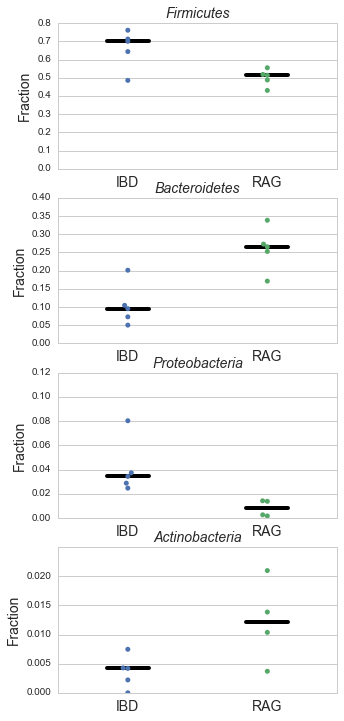

In [27]:
plot_swarm(test_tax_diff(enr_phy)[1], enr_phy, 'swarm_enriched_phylum')

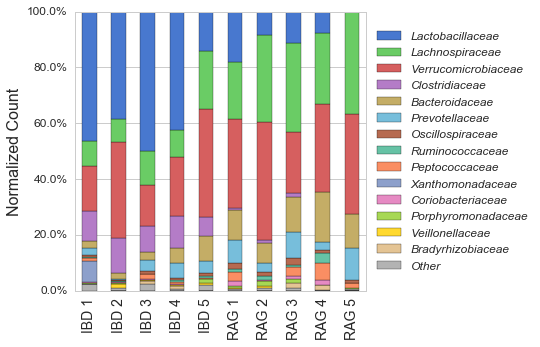

In [28]:
plot_tax(pivot_df(all_dfs['family'], 'family', n14_enr_samps+n15_enr_samps, cutoff=.03))

In [29]:
enr_fam = pivot_df(all_dfs['family'], 'family', n14_enr_samps+n15_enr_samps, cutoff=.03)
enr_fam = enr_fam.reset_index()
enr_fam = enr_fam.rename(columns={'index': 'cohort'})
enr_fam['cohort'] = enr_fam['cohort'].str.split(' ').str[0]

enr_fam_avg = enr_fam.groupby('cohort').mean()

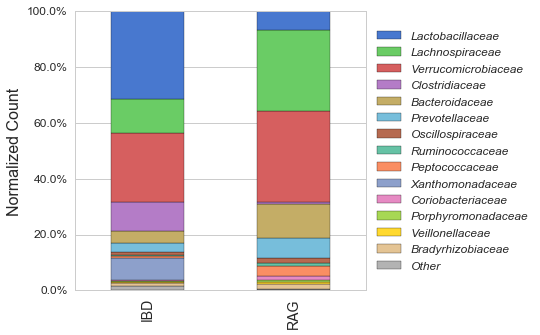

In [30]:
plot_tax(enr_fam_avg)

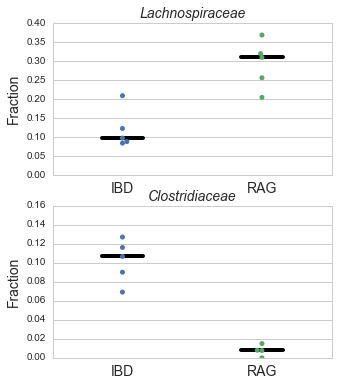

In [31]:
plot_swarm(test_tax_diff(enr_fam)[0], enr_fam, 'swarm_enriched_family')